# Import packages

In [1]:

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
if Path.cwd().parts[-1] != 'Multifirefly-Project':
    if Path.cwd().parts[-1] != 'notebooks':
        os.chdir('..')
    from add_path import find_path
    current_path = find_path()
    os.chdir(current_path)

from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.neural_analysis_by_topic.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.neural_analysis_by_topic.planning_and_neural import planning_neural_class, planning_neural_utils, planning_neural_helper_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

Changed the directory to 'Multifirefly-Project'.
Added /Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods to the path.
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compare test and control

# exp

In [ ]:
    def _add_curvature_info(self):

        self._make_curv_of_traj_df_if_not_already_made(
            **self.curv_of_traj_params)

        opt_arc_stop_first_vis_bdry = True if (
            self.opt_arc_type == 'opt_arc_stop_first_vis_bdry') else False

        self.nxt_curv_df = curvature_utils.make_curvature_df(self.nxt_ff_df_modified, self.curv_of_traj_df, clean=False, monkey_information=self.monkey_information,
                                                             ff_caught_T_new=self.ff_caught_T_new, remove_invalid_rows=False,
                                                             invalid_curvature_ok=True, opt_arc_stop_first_vis_bdry=opt_arc_stop_first_vis_bdry)
        self.cur_curv_df = curvature_utils.make_curvature_df(self.cur_ff_df_modified, self.curv_of_traj_df, clean=False, monkey_information=self.monkey_information,
                                                             ff_caught_T_new=self.ff_caught_T_new, remove_invalid_rows=False,
                                                             invalid_curvature_ok=False, opt_arc_stop_first_vis_bdry=opt_arc_stop_first_vis_bdry)

        if self.opt_arc_type == 'opt_arc_stop_closest':
            self.cur_curv_df = opt_arc_utils.update_curvature_df_to_let_opt_arc_stop_at_closest_point_to_monkey_stop(self.cur_curv_df, self.cur_ff_df_modified, self.stops_near_ff_df_modified,
                                                                                                                             self.ff_real_position_sorted, self.monkey_information)

        # use merge to add curvature_info
        shared_columns = ['ff_index', 'point_index', 'optimal_curvature', 'opt_arc_measure', 'opt_arc_radius', 'opt_arc_end_direction', 'curv_of_traj', 'curv_to_ff_center',
                          'arc_radius_to_ff_center', 'd_heading_to_center', 'opt_arc_d_heading', 'opt_arc_end_x', 'opt_arc_end_y', 'arc_end_x_to_ff_center', 'arc_end_y_to_ff_center']
        self.nxt_ff_final_df = self.nxt_ff_df_modified.merge(
            self.nxt_curv_df[shared_columns], on=['ff_index', 'point_index'], how='left')
        self.cur_ff_final_df = self.cur_ff_df_modified.merge(
            self.cur_curv_df[shared_columns], on=['ff_index', 'point_index'], how='left')


In [27]:
pn.both_ff_across_time_df.columns

Index(['nxt_arc_curv', 'nxt_opt_arc_curv', 'nxt_opt_arc_dheading',
       'nxt_ff_angle', 'nxt_ff_distance', 'cur_arc_curv', 'cur_opt_arc_curv',
       'cur_opt_arc_dheading', 'cur_ff_angle', 'cur_ff_distance',
       'stop_point_index', 'point_index', 'traj_curv', 'cur_ff_rel_x',
       'cur_ff_rel_y', 'nxt_ff_rel_x', 'nxt_ff_rel_y', 'target_index',
       'segment'],
      dtype='object')

In [26]:
pn.all_planning_info.columns

Index(['nxt_arc_curv', 'nxt_opt_arc_curv', 'nxt_opt_arc_dheading',
       'nxt_ff_angle', 'nxt_ff_distance', 'cur_arc_curv', 'cur_opt_arc_curv',
       'cur_opt_arc_dheading', 'cur_ff_angle', 'cur_ff_distance',
       'stop_point_index', 'point_index', 'traj_curv', 'cur_ff_rel_x',
       'cur_ff_rel_y', 'nxt_ff_rel_x', 'nxt_ff_rel_y', 'target_index',
       'segment', 'bin', 'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff',
       'angle_from_cur_ff_landing_to_nxt_ff'],
      dtype='object')

In [24]:
pn.all_planning_info.shape

(179947, 23)

In [23]:
pn.all_planning_info.head(3)

,nxt_arc_curv,nxt_opt_arc_curv,nxt_opt_arc_dheading,nxt_ff_angle,nxt_ff_distance,cur_arc_curv,cur_opt_arc_curv,cur_opt_arc_dheading,cur_ff_angle,cur_ff_distance,...,cur_ff_rel_x,cur_ff_rel_y,nxt_ff_rel_x,nxt_ff_rel_y,target_index,segment,bin,angle_from_m_before_stop_to_cur_ff,angle_from_m_before_stop_to_nxt_ff,angle_from_cur_ff_landing_to_nxt_ff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN


In [ ]:
    _make_curvature_df
    # it needs ff_dataframe_sub to have the following columns:
    # point_index, ff_index, monkey_x, monkey_y, monkey_angle, ff_x, ff_y, ff_distance, ff_angle, ff_angle_boundary

In [20]:
pn.planning_helper.nxt_ff_df2.head()

,ff_index,point_index,ff_x,ff_y,monkey_x,monkey_y,monkey_angle,ff_distance,ff_angle,ff_angle_boundary,stop_point_index,time,stop_time
0,2,1380,663.04853,678.14283,905.90057,42.90691,2.30853,680.07484,-0.37257,-0.35787,1500.00000,23.01927,25.01125
1,2,1381,663.04853,678.14283,905.08350,43.81038,2.29830,678.93931,-0.36299,-0.34827,1500.00000,23.03576,25.01125
2,2,1382,663.04853,678.14283,902.53772,46.68357,2.29506,675.34870,-0.36176,-0.34695,1500.00000,23.05246,25.01125
3,2,1383,663.04853,678.14283,901.71173,47.62185,2.28520,674.17864,-0.35255,-0.33772,1500.00000,23.06896,25.01125
4,2,1384,663.04853,678.14283,899.22406,50.50462,2.28199,670.60316,-0.35130,-0.33638,1500.00000,23.08567,25.01125


In [19]:
pn.planning_helper.nxt_ff_final_df.head()

,ff_index,point_index,ff_x,ff_y,monkey_x,monkey_y,monkey_angle,ff_distance,ff_angle,ff_angle_boundary,...,opt_arc_d_heading,opt_arc_end_x,opt_arc_end_y,arc_end_x_to_ff_center,arc_end_y_to_ff_center,d_heading_of_arc,arc_end_x,arc_end_y,monkey_angle_before_stop,d_heading_of_traj
0,2,1386,663.04853,678.14283,895.90662,54.42482,2.27044,665.76801,-0.34233,-0.32731,...,-0.72408,677.07204,677.80015,663.04853,678.14283,-0.72408,677.07204,677.80015,1.49714,-0.77331
1,3,1658,420.04353,731.37276,735.28571,574.60754,2.06071,352.06954,0.61941,0.59100,...,1.17996,418.81043,743.77697,420.04353,731.37276,1.17996,418.81043,743.77697,2.22708,0.16637
2,9,2820,279.13225,135.19206,626.83307,-71.02530,2.69236,404.25421,-0.08609,-0.06135,...,-0.09813,271.33509,122.39897,279.13225,135.19206,-0.09813,271.33509,122.39897,2.59410,-0.09826
3,10,2992,250.33246,178.98227,440.17606,43.13102,2.47203,233.44412,0.04845,0.00560,...,0.00023,257.32987,187.82674,250.33245,178.98227,0.00023,257.32987,187.82674,2.64706,0.17503
4,12,3420,-213.00578,848.74968,-46.08485,493.64774,2.15059,392.37735,-0.14037,-0.11489,...,-0.20508,-226.89165,843.28844,-213.00578,848.74968,-0.20508,-226.89165,843.28844,2.13693,-0.01365


In [21]:
pn.planning_helper.nxt_ff_df_modified.head()

,ff_index,point_index,ff_x,ff_y,monkey_x,monkey_y,monkey_angle,ff_distance,ff_angle,ff_angle_boundary,stop_point_index
0,2,1386,663.04853,678.14283,895.90662,54.42482,2.27044,665.76801,-0.34233,-0.32731,1500
1,3,1658,420.04353,731.37276,735.28571,574.60754,2.06071,352.06954,0.61941,0.59100,1767
2,9,2820,279.13225,135.19206,626.83307,-71.02530,2.69236,404.25421,-0.08609,-0.06135,2924
3,10,2992,250.33246,178.98227,440.17606,43.13102,2.47203,233.44412,0.04845,0.00560,3073
4,12,3420,-213.00578,848.74968,-46.08485,493.64774,2.15059,392.37735,-0.14037,-0.11489,3441


# Retrieve data

In [2]:
# add columns not in pn.behav_all_data to all_planning_info, merging by point_index

# need to make sure their point_index match though....raise a warning if there's point_index in all_planning_info but not in pn.behav_all_data

## get data

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [4]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"

In [5]:
# pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
# pn.get_behav_data(exists_ok=False)

In [32]:
ref_point_mode='time after cur ff visible'
ref_point_value=0.1
normalize = False
eliminate_outliers = False
use_curvature_to_ff_center = False
curv_of_traj_mode = 'distance'
window_for_curv_of_traj=[-25, 25]
truncate_curv_of_traj_by_time_of_capture = True

pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(both_ff_across_time_df_exists_ok=False)
pn.get_x_and_y_data_for_modeling(exists_ok=False)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
Retrieved target_df
Retrieved target_cluster_df
Window width changed from 0.25 to 0.26 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p02.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 225 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 225 rows
Retrieving shared_stops_near_ff_df succeeded
Retrieving stop_0_1_window_-50cm_0cm from all_monkey_data/planning/monkey_Schro/data_0416/diff_in_curv_df/opt_arc_stop_closest/test/stop_0_1_

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/neural_analysis_by_topic/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(


Having processed 0 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 10 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 20 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 30 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 40 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 50 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 60 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 70 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 80 rows out of 89 of the stops_near_ff_df for both_ff_across_time_df.
Index(['monkey_x', 'monkey_y', 'time', 'point_index', 'monkey_angle',
       'monkey_speed', 'monkey_dw', 'RDz', 'monkey_y_smr', 'monkey_dw_smr',
       'RDy', 'monkey_x_smr', 'LDy', 'LDz', 'monkey_speed_smr',
       '

## see data

In [29]:
pn.y_var.columns

Index(['bin', 'nxt_arc_curv', 'nxt_opt_arc_curv', 'nxt_opt_arc_dheading',
       'nxt_ff_angle', 'nxt_ff_distance', 'cur_arc_curv', 'cur_opt_arc_curv',
       'cur_opt_arc_dheading', 'cur_ff_angle', 'cur_ff_distance', 'traj_curv',
       'cur_ff_rel_x', 'cur_ff_rel_y', 'nxt_ff_rel_x', 'nxt_ff_rel_y',
       'target_index', 'segment', 'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff',
       'angle_from_cur_ff_landing_to_nxt_ff'],
      dtype='object')

In [7]:
pn.y_var.groupby('segment').count()['bin'].max()

156

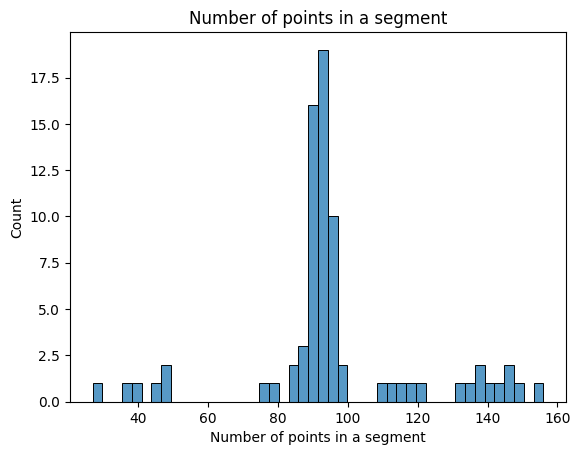

In [8]:
sns.histplot(pn.y_var.groupby('segment').count()['bin'])
plt.xlabel('Number of points in a segment')
plt.title('Number of points in a segment')
plt.show()

In [9]:
pn.y_var.columns.tolist()

['nxt_arc_curv',
 'nxt_opt_arc_curv',
 'nxt_opt_arc_dheading',
 'nxt_ff_angle',
 'nxt_ff_distance',
 'cur_arc_curv',
 'cur_opt_arc_curv',
 'cur_opt_arc_dheading',
 'cur_ff_angle',
 'cur_ff_distance',
 'traj_curv',
 'cur_ff_rel_x',
 'cur_ff_rel_y',
 'nxt_ff_rel_x',
 'nxt_ff_rel_y',
 'target_index',
 'segment',
 'bin',
 'angle_from_m_before_stop_to_cur_ff',
 'angle_from_m_before_stop_to_nxt_ff',
 'angle_from_cur_ff_landing_to_nxt_ff']

## check final VIF

In [10]:
vif_df = drop_high_vif_vars.get_vif_df(pn.y_var_reduced)
vif_df

,feature,vif
8,angle_from_m_before_stop_to_nxt_ff,2.60000
2,cur_ff_angle,2.30000
4,cur_ff_rel_x,2.10000
6,bin,2.00000
5,cur_ff_rel_y,2.00000
0,nxt_arc_curv,1.90000
9,angle_from_cur_ff_landing_to_nxt_ff,1.90000
3,traj_curv,1.60000
1,cur_arc_curv,1.60000
7,angle_from_m_before_stop_to_cur_ff,1.30000


In [11]:
vif_df = drop_high_vif_vars.get_vif_df(pn.y_var_lags_reduced)
vif_df

,feature,vif
5,cur_arc_curv_0,4.40000
6,cur_arc_curv_4,3.90000
7,cur_ff_angle_0,2.60000
2,angle_from_m_before_stop_to_nxt_ff_0,2.60000
4,cur_arc_curv_-5,2.60000
8,cur_ff_rel_x_0,2.10000
3,bin,2.00000
9,cur_ff_rel_y_0,2.00000
10,nxt_arc_curv_0,1.90000
0,angle_from_cur_ff_landing_to_nxt_ff_0,1.90000


## check correlations in y_var_lags

In [12]:
# sort pn.y_var_lags by column str a to z
pn.y_var_lags2 = pn.y_var_lags.reindex(sorted(pn.y_var_lags.columns), axis=1)

# # sort pn.y_var_lags by column str z to a
# pn.y_var_lags_reduced = pn.y_var_lags_reduced.reindex(sorted(pn.y_var_lags_reduced.columns, reverse=True), axis=1)

In [13]:
pn.y_var_lags2.iloc[:, :10]

,angle_from_cur_ff_landing_to_nxt_ff_-1,angle_from_cur_ff_landing_to_nxt_ff_-2,angle_from_cur_ff_landing_to_nxt_ff_-3,angle_from_cur_ff_landing_to_nxt_ff_-4,angle_from_cur_ff_landing_to_nxt_ff_-5,angle_from_cur_ff_landing_to_nxt_ff_0,angle_from_cur_ff_landing_to_nxt_ff_1,angle_from_cur_ff_landing_to_nxt_ff_2,angle_from_cur_ff_landing_to_nxt_ff_3,angle_from_cur_ff_landing_to_nxt_ff_4
0,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960
1,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960
2,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960
3,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960
4,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960
...,...,...,...,...,...,...,...,...,...,...
7192,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593
7193,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593
7194,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593
7195,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593


In [14]:
df = pn.y_var_lags2
df

,angle_from_cur_ff_landing_to_nxt_ff_-1,angle_from_cur_ff_landing_to_nxt_ff_-2,angle_from_cur_ff_landing_to_nxt_ff_-3,angle_from_cur_ff_landing_to_nxt_ff_-4,angle_from_cur_ff_landing_to_nxt_ff_-5,angle_from_cur_ff_landing_to_nxt_ff_0,angle_from_cur_ff_landing_to_nxt_ff_1,angle_from_cur_ff_landing_to_nxt_ff_2,angle_from_cur_ff_landing_to_nxt_ff_3,angle_from_cur_ff_landing_to_nxt_ff_4,...,traj_curv_-2,traj_curv_-3,traj_curv_-4,traj_curv_-5,traj_curv_0,traj_curv_1,traj_curv_2,traj_curv_3,traj_curv_4,traj_curv_5
0,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,...,-0.00179,-0.00176,-0.00160,-0.00137,-0.00198,-0.00198,-0.00198,-0.00198,-0.00198,-0.00198
1,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,...,-0.00176,-0.00160,-0.00137,-0.00109,-0.00196,-0.00198,-0.00198,-0.00198,-0.00198,-0.00198
2,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,...,-0.00160,-0.00137,-0.00109,-0.00097,-0.00179,-0.00196,-0.00198,-0.00198,-0.00198,-0.00198
3,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,...,-0.00137,-0.00109,-0.00097,-0.00088,-0.00176,-0.00179,-0.00196,-0.00198,-0.00198,-0.00198
4,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,0.36960,...,-0.00109,-0.00097,-0.00088,-0.00068,-0.00160,-0.00176,-0.00179,-0.00196,-0.00198,-0.00198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,...,0.00069,0.00069,0.00064,0.00064,0.00069,0.00069,0.00069,0.00069,0.00069,0.00069
7193,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,...,0.00069,0.00064,0.00064,0.00064,0.00069,0.00069,0.00069,0.00069,0.00069,0.00069
7194,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,...,0.00064,0.00064,0.00064,0.00064,0.00069,0.00069,0.00069,0.00069,0.00069,0.00069
7195,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,0.17593,...,0.00064,0.00064,0.00064,0.00064,0.00069,0.00069,0.00069,0.00069,0.00069,0.00069


In [15]:
pn.y_var_lags2.iloc[:, :10].corr()

,angle_from_cur_ff_landing_to_nxt_ff_-1,angle_from_cur_ff_landing_to_nxt_ff_-2,angle_from_cur_ff_landing_to_nxt_ff_-3,angle_from_cur_ff_landing_to_nxt_ff_-4,angle_from_cur_ff_landing_to_nxt_ff_-5,angle_from_cur_ff_landing_to_nxt_ff_0,angle_from_cur_ff_landing_to_nxt_ff_1,angle_from_cur_ff_landing_to_nxt_ff_2,angle_from_cur_ff_landing_to_nxt_ff_3,angle_from_cur_ff_landing_to_nxt_ff_4
angle_from_cur_ff_landing_to_nxt_ff_-1,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_-2,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_-3,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_-4,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_-5,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_1,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_2,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_3,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
angle_from_cur_ff_landing_to_nxt_ff_4,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


# debug

In [16]:
        var_df_lags_reduced, top_values_by_feature, columns_dropped = drop_lags_with_high_corr_or_vif_for_each_feature(
            var_df_lags_reduced,
            corr_threshold=corr_threshold_for_lags,
            verbose=verbose
        )

NameError: name 'drop_lags_with_high_corr_or_vif_for_each_feature' is not defined

In [26]:
df_with_lags = pn.y_var_lags2.copy()
num_original_columns = len(df_with_lags.columns)
base_features = drop_high_corr_vars.get_base_feature_names(df_with_lags)
columns_dropped = []
top_values_by_feature = pd.DataFrame()
for i, feature in enumerate(base_features):
    df_with_lags_sub = drop_high_corr_vars._find_subset_of_df_with_lags_for_current_feature(
        df_with_lags, feature)
    # temp_columns_to_drop, top_values_of_feature = drop_high_corr_vars._drop_lags_for_feature(
    #     df_with_lags, feature, corr_threshold, vif_threshold, use_vif_instead_of_corr, drop_lag_0_last_in_vif)
    if df_with_lags_sub.corr().iloc[1,2] == 1:
        print(feature)

angle_from_m_before_stop_to_cur_ff
angle_from_cur_ff_landing_to_nxt_ff
segment
angle_from_m_before_stop_to_nxt_ff
target_index


1.0

# LR

In [30]:
# With x var lags
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_lags_reduced, pn.y_var)
pn.y_var_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.72966,0.53240,0.00000,True
1,target_index,0.72695,0.52845,0.00000,True
2,segment,0.72286,0.52252,0.00000,True
3,cur_ff_distance,0.68885,0.47451,0.00000,True
4,cur_ff_rel_y,0.68681,0.47171,0.00000,True
5,cur_ff_rel_x,0.58685,0.34440,0.00000,True
6,nxt_ff_distance,0.58342,0.34038,0.00000,True
7,nxt_ff_rel_y,0.58035,0.33681,0.00000,True
8,cur_opt_arc_dheading,0.56859,0.32329,0.00000,True
9,cur_opt_arc_curv,0.55747,0.31077,0.00000,True


In [15]:
# With x var lags
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_lags_reduced, pn.y_var_lags_reduced)
pn.y_var_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.72966,0.53240,0.00000,True
1,cur_ff_rel_y_0,0.68681,0.47171,0.00000,True
2,cur_ff_rel_x_0,0.58685,0.34440,0.00000,True
3,traj_curv_0,0.53988,0.29147,0.00000,True
4,cur_ff_angle_0,0.50274,0.25275,0.00000,True
5,cur_arc_curv_4,0.49249,0.24254,0.00000,True
6,cur_arc_curv_-5,0.48245,0.23276,0.00000,True
7,cur_arc_curv_0,0.48038,0.23076,0.00000,True
8,nxt_arc_curv_0,0.47638,0.22694,0.00000,True
9,angle_from_m_before_stop_to_nxt_ff_0,0.46542,0.21662,0.00000,True


In [16]:
# With x var lags
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_lags_reduced, pn.y_var_lags_reduced)
pn.y_var_lr_df

KeyboardInterrupt: 

In [ ]:
# With x var lags
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_lags_reduced, pn.y_var_lags_reduced)
pn.y_var_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.73746,0.54385,0.00000,True
1,cur_ff_rel_x_0,0.55376,0.30665,0.00000,True
2,time_rel_to_stop_0,0.54901,0.30141,0.00000,True
3,traj_curv_0,0.52449,0.27509,0.00000,True
4,cur_ff_angle_0,0.48550,0.23571,0.00000,True
5,cur_arc_curv_4,0.46052,0.21208,0.00000,True
6,cur_arc_curv_0,0.44435,0.19745,0.00000,True
7,nxt_arc_curv_0,0.44216,0.19550,0.00000,True
8,cur_arc_curv_-5,0.43777,0.19165,0.00000,True
9,angle_from_cur_ff_landing_to_nxt_ff_0,0.41611,0.17315,0.00000,True


In [ ]:
# no lags on x var
pn.y_var_no_lag_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_reduced, pn.y_var_reduced)
pn.y_var_no_lag_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.34594,0.11968,0.00000,True
1,time_rel_to_stop,0.28502,0.08124,0.00000,True
2,cur_opt_arc_dheading,0.25445,0.06474,0.00000,True
3,traj_curv,0.23169,0.05368,0.00000,True
4,cur_ff_angle,0.19974,0.03990,0.00000,True
5,cur_arc_curv,0.17847,0.03185,0.00000,True
6,nxt_arc_curv,0.16909,0.02859,0.00000,True
7,angle_from_cur_ff_landing_to_nxt_ff,0.15279,0.02334,0.00000,True
8,angle_from_m_before_stop_to_nxt_ff,0.14467,0.02093,0.00000,True
9,angle_from_m_before_stop_to_cur_ff,0.14001,0.01960,0.00000,True


In [ ]:
x_var = pn.x_var_lags_reduced
y_var = pn.y_var_reduced

# Plot linear regression on X and y
max_plot_number = 10
count = 0
bins_to_plot = range(len(pn.y_var))

for i, column in enumerate(pn.y_var_lr_df.feature.values): # so that features are plotted in the order of correlation
    if i >= max_plot_number:
        break
    plot_neural_data.plot_regression(y_var, column, x_var, bins_to_plot=None, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.35319 0.30212 0.23695 0.19923 0.16833 0.15385 0.13603 0.12467 0.11017
 0.10621]
% Shared Variance: [0.12474 0.09127 0.05615 0.03969 0.02833 0.02367 0.0185  0.01554 0.01214
 0.01128]


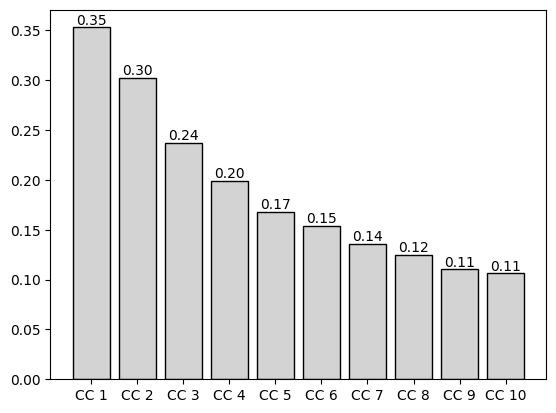

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.75247 0.67723 0.55874 0.48508 0.45654 0.43133 0.40216 0.40094 0.38288
 0.36528]
% Shared Variance: [0.56621 0.45864 0.31219 0.2353  0.20842 0.18604 0.16174 0.16075 0.1466
 0.13343]


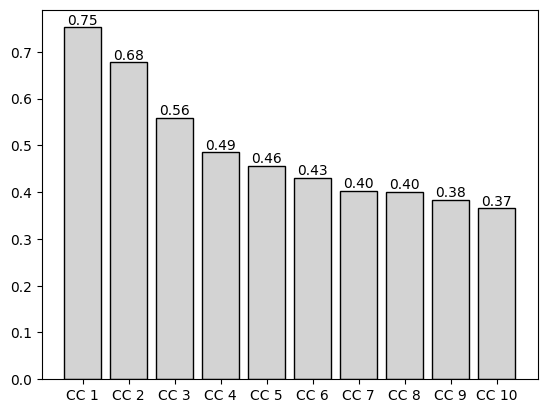

pn.x_var_lags.shape: (8458, 946)
pn.y_var_lags_reduced.shape: (8458, 14)


In [ ]:
cca_no_lag = cca_class.CCAclass(X1=pn.x_var_reduced, X2=pn.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=pn.x_var_lags_reduced.drop(columns='bin', errors='ignore'), X2=pn.y_var_lags_reduced, lagging_included=True)
# for all columns that end with _0, rename them to the column name without the _0
cca_lags.X2.columns = cca_lags.X2.columns.str.replace('_0', '')
cca_lags.conduct_cca()


print(f'pn.x_var_lags.shape: {pn.x_var_lags.shape}')
print(f'pn.y_var_lags_reduced.shape: {pn.y_var_lags_reduced.shape}')

cca_inst = cca_lags

## compare lag vs no lag

In [140]:
can_load_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
can_load_df[f'with_lags'] = cca_lags.canon_corr
can_load_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert can_load_df to long format
can_load_df_long = pd.melt(can_load_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

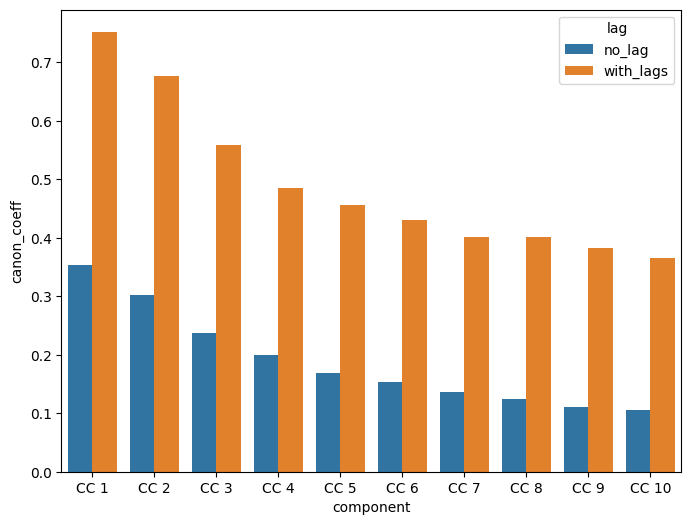

In [141]:
# make a sns bar plot on can_load_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=can_load_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [142]:
# choose no lag
cca_inst = cca_no_lag

In [143]:
# choose lags
cca_inst = cca_lags

## test for p values

In [9]:
cca_inst.test_for_p_values()

# Heatmap of loadings

## X1 loadings

In [ ]:
# cca_inst.plot_X1_loadings()

## X2 loadings

In [159]:
pn.y_var_lags_reduced.columns

Index(['angle_from_cur_ff_landing_to_nxt_ff',
       'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff', 'bin', 'cur_arc_curv_-5',
       'cur_arc_curv', 'cur_arc_curv_5', 'cur_ff_angle_-5', 'cur_ff_angle_5',
       'cur_ff_distance', 'cur_opt_arc_dheading', 'index', 'nxt_arc_curv',
       'traj_curv'],
      dtype='object')

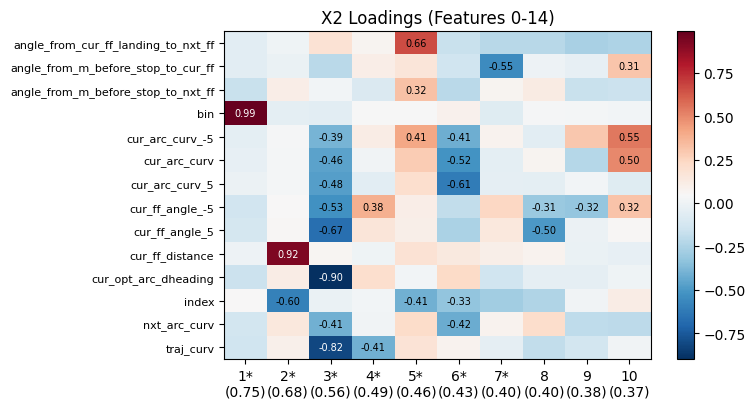

In [ ]:
cca_inst.plot_X2_loadings()

In [ ]:
pn.y_var_lags_reduced.corr()

,angle_from_cur_ff_landing_to_nxt_ff,angle_from_m_before_stop_to_cur_ff,angle_from_m_before_stop_to_nxt_ff,bin,cur_arc_curv_-5,cur_arc_curv,cur_arc_curv_5,cur_ff_angle_-5,cur_ff_angle_5,cur_ff_distance,cur_opt_arc_dheading,index,nxt_arc_curv,traj_curv
angle_from_cur_ff_landing_to_nxt_ff,1.00000,0.05374,0.70910,-0.05888,0.04636,0.04429,0.04774,0.03653,0.02641,-0.04716,-0.04724,0.06746,0.40390,0.07807
angle_from_m_before_stop_to_cur_ff,0.05374,1.00000,0.02391,0.00120,0.39087,0.39713,0.36182,0.39877,0.34476,0.01479,0.18239,-0.00318,0.09272,0.11844
angle_from_m_before_stop_to_nxt_ff,0.70910,0.02391,1.00000,-0.19605,0.04777,0.04680,0.05427,0.07161,0.07435,-0.02244,0.02194,0.05699,0.60718,0.15035
bin,-0.05888,0.00120,-0.19605,1.00000,-0.02654,-0.02616,-0.02566,-0.12824,-0.12015,-0.03389,-0.07670,0.04785,-0.14643,-0.11080
cur_arc_curv_-5,0.04636,0.39087,0.04777,-0.02654,1.00000,0.73644,0.58990,0.58454,0.45387,0.01239,0.30543,0.02384,0.21849,0.32775
cur_arc_curv,0.04429,0.39713,0.04680,-0.02616,0.73644,1.00000,0.73648,0.59255,0.50889,0.01028,0.31175,0.02344,0.20683,0.37605
cur_arc_curv_5,0.04774,0.36182,0.05427,-0.02566,0.58990,0.73648,1.00000,0.48134,0.58694,0.02477,0.26549,-0.00648,0.17787,0.36515
cur_ff_angle_-5,0.03653,0.39877,0.07161,-0.12824,0.58454,0.59255,0.48134,1.00000,0.73708,0.03798,0.52193,-0.00940,0.27186,0.40279
cur_ff_angle_5,0.02641,0.34476,0.07435,-0.12015,0.45387,0.50889,0.58694,0.73708,1.00000,0.02009,0.53731,-0.01673,0.25471,0.51470
cur_ff_distance,-0.04716,0.01479,-0.02244,-0.03389,0.01239,0.01028,0.02477,0.03798,0.02009,1.00000,0.02164,-0.84516,0.01365,0.01884


# Canonical Variate scatterplots

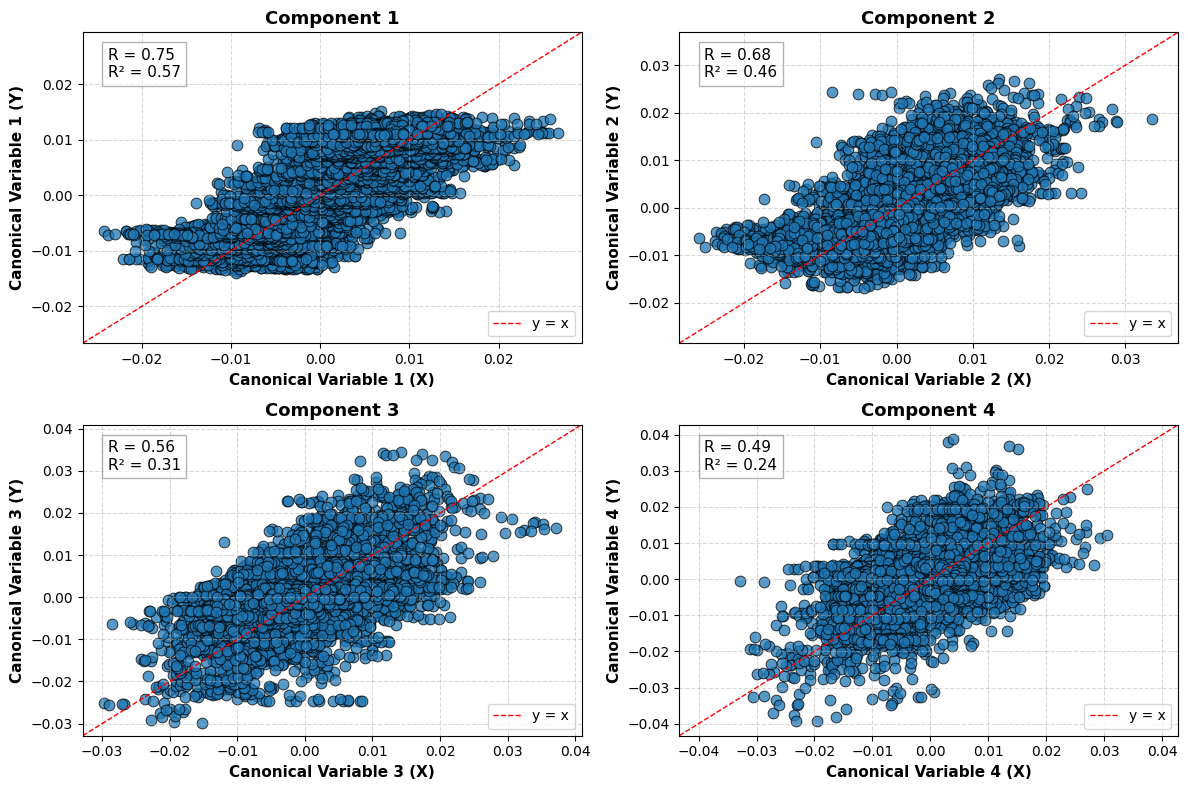

In [145]:
components=range(1, 5)
cca_plotting.plot_cca_component_scatter(cca_inst.X1_c, cca_inst.X2_c, components=components, show_y_eq_x=True)


# Transform vars (e.g. use basis functions)

In [147]:
cca_no_lag.X2_tf_df = transform_vars.transform_behav_data(cca_no_lag.X2)
cca_lags.X2_tf_df = transform_vars.transform_behav_data(cca_lags.X2)

In [148]:
# If need to use the data
cca_inst = cca_lags
X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_tf_df


# Lags vs no lag & train vs test

## Get data

In [ ]:
combined_cross_view_df, combined_can_load_df = cca_cv_utils.combine_cv_results(cca_no_lag, cca_lags, n_components=7, reg=0.1, n_splits=7)

Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


## cross-view X1

In [ ]:
# dataset_name = 'X1'
# cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
# cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


## cross-view X2

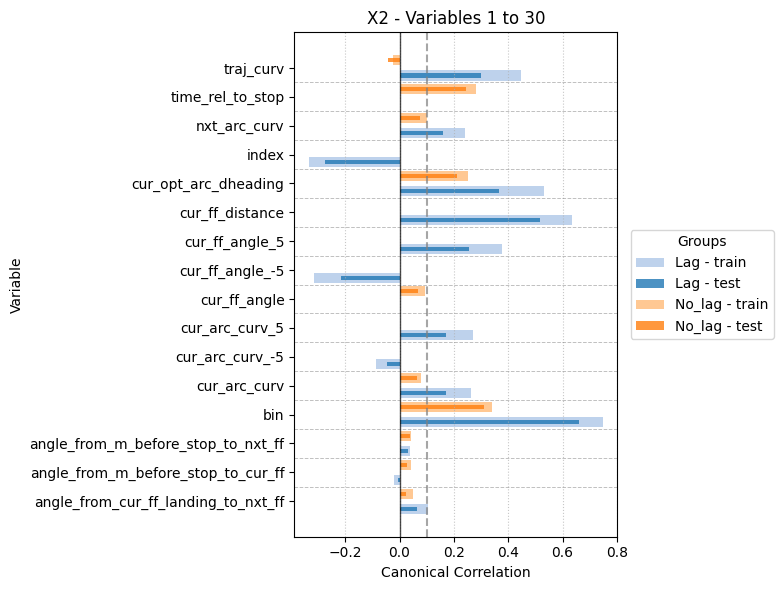

In [ ]:
dataset_name = 'X2'
cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


# Just train vs test

## cross-view X1

In [ ]:
# filter_significant = True
# sort_by_significance = True
# significance_threshold = 4
# whether_lag = 'lag'

# combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# # X1
# cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X1',
#                                     filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


## cross-view X2

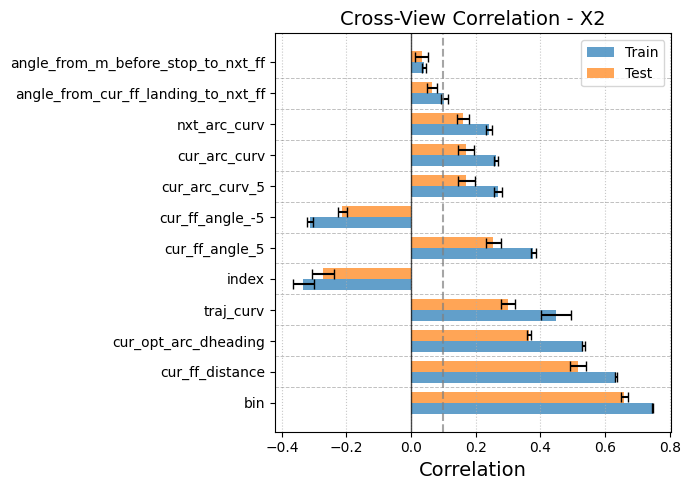

In [58]:
filter_significant = True
sort_by_significance = True
significance_threshold = 1
whether_lag = 'lag'

combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# X2
cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X2',
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


# Appendix

## debug

In [ ]:
# general_utils.check_na_in_df(df = pn.y_var_lags, col = 'point_index', raise_warning = True)

## Compare columns in behav_data (target_decoder) and final_behavioral_data (neural_vs_behavioral_class)

In [ ]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
pn.get_behav_data(exists_ok=False)

In [ ]:
data_item = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
data_item.streamline_preparing_neural_and_behavioral_data()

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
When take out monkey subset for GUAT, 144 clusters out of 254 are too close to the target or the last target. Those clusters are filtered out.
The number of new trials that are used to separate stop clusters is 470
Retrieved all_trial_patterns
Retrieved pattern_frequencies
Retrieved all_trial_features
Retrieved feature_statistics
Retrieved scatter_around_target_df


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/neural_analysis_by_topic/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(


Retrieved target_df
Retrieved target_cluster_df
Window width changed from 0.25 to 0.26 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p02.csv


In [ ]:
# Columns in pn.behav_data_all but not in data_item.final_behavioral_data
only_in_pn = set(pn.behav_data_all.columns) - set(data_item.final_behavioral_data.columns)
print("Columns only in pn.behav_data_all:")
only_in_pn = np.array(sorted(only_in_pn))
print(only_in_pn)
print('\n \n')

# Columns in data_item.final_behavioral_data but not in pn.behav_data_all
final_behavioral_data_columns = data_item.final_behavioral_data.columns
# remove all 'avg_bin_' prefix
final_behavioral_data_columns = [col.replace('avg_bin_', '') for col in final_behavioral_data_columns]
only_in_data_item = set(final_behavioral_data_columns) - set(pn.behav_data_all.columns)
print("Columns only in data_item.final_behavioral_data:")
only_in_data_item = np.array(sorted(only_in_data_item))
print(only_in_data_item)

Columns only in pn.behav_data_all:
['bin_end_time' 'bin_start_time' 'capture_target_dummy'
 'crossing_boundary' 'cum_distance' 'cum_distance_since_target_last_seen'
 'cum_distance_when_target_last_seen' 'current_target_caught_time'
 'd_heading_since_target_last_seen' 'delta_distance'
 'distance_from_monkey_pos_target_last_seen' 'dt' 'eye_world_speed'
 'gaze_mky_view_angle' 'gaze_mky_view_angle_l' 'gaze_mky_view_angle_r'
 'gaze_mky_view_x_l' 'gaze_mky_view_x_r' 'gaze_mky_view_y_l'
 'gaze_mky_view_y_r' 'gaze_world_x_l' 'gaze_world_x_r' 'gaze_world_y_l'
 'gaze_world_y_r' 'last_target_caught_time'
 'monkey_angle_target_last_seen' 'monkey_dw_smr' 'monkey_speed_smr'
 'monkey_speeddummy' 'monkey_x' 'monkey_x_smr' 'monkey_x_target_last_seen'
 'monkey_y' 'monkey_y_smr' 'monkey_y_target_last_seen' 'point_index'
 'target_angle' 'target_angle_to_boundary'
 'target_cluster_has_disappeared_for_last_time_dummy'
 'target_cluster_last_seen_angle' 'target_cluster_last_seen_angle_frozen'
 'target_cluster

In [35]:
pn.cur_and_nxt_ff_df.columns

AttributeError: 'PlanningAndNeural' object has no attribute 'cur_and_nxt_ff_df'

In [34]:
pn.planning_helper.heading_info_df.columns

Index(['stop_point_index', 'stop_x', 'stop_y', 'stop_time', 'cur_ff_index',
       'cur_ff_x', 'cur_ff_y', 'cur_ff_cluster_50_size',
       'point_index_before_stop', 'monkey_angle_before_stop',
       'next_stop_point_index', 'next_stop_time',
       'cum_distance_between_two_stops', 'curv_range', 'curv_iqr',
       'nxt_ff_index', 'nxt_ff_x', 'nxt_ff_y', 'NXT_time_ff_last_seen_bbas',
       'NXT_time_ff_last_seen_bsans', 'nxt_ff_last_flash_time_bbas',
       'nxt_ff_last_flash_time_bsans', 'nxt_ff_cluster_last_seen_time_bbas',
       'nxt_ff_cluster_last_seen_time_bsans',
       'nxt_ff_cluster_last_flash_time_bbas',
       'nxt_ff_cluster_last_flash_time_bsans', 'mx_before_stop',
       'my_before_stop', 'cur_arc_end_heading', 'nxt_arc_end_heading',
       'cur_arc_end_x', 'cur_arc_end_y', 'd_heading_of_traj',
       'cur_d_heading_of_arc', 'ref_monkey_angle', 'ref_curv_of_traj',
       'nxt_d_heading_of_arc', 'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to

## just get both_ff_across_time_df

In [ ]:
both_ff_across_time_df_exists_ok = True

raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
ref_point_mode='time after cur ff visible'
ref_point_value=0.1
normalize = False
eliminate_outliers = False
use_curvature_to_ff_center = False
curv_of_traj_mode = 'distance'
window_for_curv_of_traj=[-25, 25]
truncate_curv_of_traj_by_time_of_capture = True

bin_width=0.02
window_width=0.25
one_behav_idx_per_bin=True

        # get behavioral_data
ph = planning_neural_helper_class.PlanningAndNeuralHelper(raw_data_folder_path=raw_data_folder_path,
                                                                               bin_width=bin_width,
                                                                               window_width=window_width,
                                                                               one_behav_idx_per_bin=one_behav_idx_per_bin)

ph.load_raw_data(raw_data_folder_path)
ph.prep_behav_data_to_analyze_planning(ref_point_mode=ref_point_mode,
                                                            ref_point_value=ref_point_value,
                                                            curv_of_traj_mode=curv_of_traj_mode,
                                                            window_for_curv_of_traj=window_for_curv_of_traj,
                                                            truncate_curv_of_traj_by_time_of_capture=truncate_curv_of_traj_by_time_of_capture,
                                                            use_curvature_to_ff_center=use_curvature_to_ff_center,
                                                            eliminate_outliers=eliminate_outliers,
                                                            both_ff_across_time_df_exists_ok=both_ff_across_time_df_exists_ok,
                                                            test_or_control='test'
                                                            )

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 768 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 768 rows
Retrieving shared_stops_near_ff_df succeeded
Retrieving stop_0_1_window_-50cm_0cm from all_monkey_data/planning/monkey_Bruno/data_0330/diff_in_curv_df/opt_arc_stop_closest/test/stop_0_1_window_-50cm_0cm succeeded
Retrieving Bruno_stop_0_1 from all_monkey_data/planning/monkey_Bruno/data_0330/heading_info_df/opt_arc_stop_closest/test/Bruno_stop_0_1 succeeded
Window width changed from 0.25 to 0.26 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0330

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/neural_analysis_by_topic/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(
